In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from diffusers import PNDMScheduler, DDIMScheduler, DPMSolverMultistepScheduler, KDPM2DiscreteScheduler, DEISMultistepScheduler

from pts.model.time_grad import TimeGradEstimator
from pts.dataset.repository.datasets import dataset_recipes

## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [7]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

## Evaluator

In [8]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `TimeGrad`

In [42]:
scheduler = PNDMScheduler(
    num_train_timesteps=100,
    beta_end=0.2,
    beta_schedule="squaredcos_cap_v2",
)

In [41]:
scheduler = DDPMScheduler(
    num_train_timesteps=100,
    beta_end=0.1,
    beta_schedule="squaredcos_cap_v2",
    thresholding=True,
    clip_sample=False,
)

In [19]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [20]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*3,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator='gpu', devices='1'),
)

In [21]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | In sizes | Out sizes        
-----------------------------------------------------------------------
0 | model | TimeGradModel | 186 K  | ?        | [1, 100, 24, 137]
--

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.36582 (best 0.36582), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.11246 (best 0.11246), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.07935 (best 0.07935), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.06905 (best 0.06905), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.06362 (best 0.06362), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 0.05723 (b

Epoch 68, global step 3450: 'train_loss' reached 0.03866 (best 0.03866), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=68-step=3450.ckpt' as top 1
Epoch 69, global step 3500: 'train_loss' was not in top 1
Epoch 70, global step 3550: 'train_loss' was not in top 1
Epoch 71, global step 3600: 'train_loss' was not in top 1
Epoch 72, global step 3650: 'train_loss' was not in top 1
Epoch 73, global step 3700: 'train_loss' was not in top 1
Epoch 74, global step 3750: 'train_loss' was not in top 1
Epoch 75, global step 3800: 'train_loss' was not in top 1
Epoch 76, global step 3850: 'train_loss' was not in top 1
Epoch 77, global step 3900: 'train_loss' reached 0.03826 (best 0.03826), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_62/checkpoints/epoch=77-step=3900.ckpt' as top 1
Epoch 78, global step 3950: 'train_loss' was not in top 1
Epoch 79, global step 4000: 'train_loss' was not in top 1
Epoch 80, global step 4050: 'train

Epoch 176, global step 8850: 'train_loss' was not in top 1
Epoch 177, global step 8900: 'train_loss' was not in top 1
Epoch 178, global step 8950: 'train_loss' was not in top 1
Epoch 179, global step 9000: 'train_loss' was not in top 1
Epoch 180, global step 9050: 'train_loss' was not in top 1
Epoch 181, global step 9100: 'train_loss' was not in top 1
Epoch 182, global step 9150: 'train_loss' was not in top 1
Epoch 183, global step 9200: 'train_loss' was not in top 1
Epoch 184, global step 9250: 'train_loss' was not in top 1
Epoch 185, global step 9300: 'train_loss' was not in top 1
Epoch 186, global step 9350: 'train_loss' was not in top 1
Epoch 187, global step 9400: 'train_loss' was not in top 1
Epoch 188, global step 9450: 'train_loss' was not in top 1
Epoch 189, global step 9500: 'train_loss' was not in top 1
Epoch 190, global step 9550: 'train_loss' was not in top 1
Epoch 191, global step 9600: 'train_loss' reached 0.03481 (best 0.03481), saving model to '/mnt/scratch/kashif/time

In [22]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 100.45it/s]

Running evaluation: 7it [00:00, 101.54it/s]

Running evaluation: 7it [00:00, 99.97it/s]

Running evaluation: 7it [00:00, 100.57it/s]

Running evaluation: 7it [00:00, 100.62it/s]

Running evaluation: 7it [00:00, 100.02it/s]

Running evaluation: 7it [00:00, 100.10it/s]

Running evaluation: 7it [00:00, 100.21it/s]

Running evaluation: 7it [00:00, 100.53it/s]

Running evaluation: 7it [00:00, 100.41it/s]

Running evaluation: 7it [00:00, 99.97it/s]

Running evaluation: 7it [00:00, 101.18it/s]

Running evaluation: 7it [00:00, 100.28it/s]

Running evaluation: 7it [00:00, 100.36it/s]

Running evaluation: 7it [00:00, 100.45it/s]

Running evaluation: 7it [00:00, 100.92it/s]

Running evaluation: 7it [00:00, 100.70it/s]

Running evaluation: 7it [00:00, 100.14it/s]

Running evaluation: 7it [00:00, 100.44it/s]

Running evaluation: 7it [00:00, 103.03it/s]

Running evaluation: 7it [00:00, 103.12it/s]

Running evaluation: 7it [00:00, 102.50it/s]

Running eva

### Metrics

In [23]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.32107541763328784
ND: 0.40383049161268403
NRMSE: 0.8585451160580138
MSE: 699.2042050015234


In [24]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.2608246852736393
ND-Sum: 0.3110448478883649
NRMSE-Sum: 0.5985498276918407
MSE-Sum: 6378514.738095239


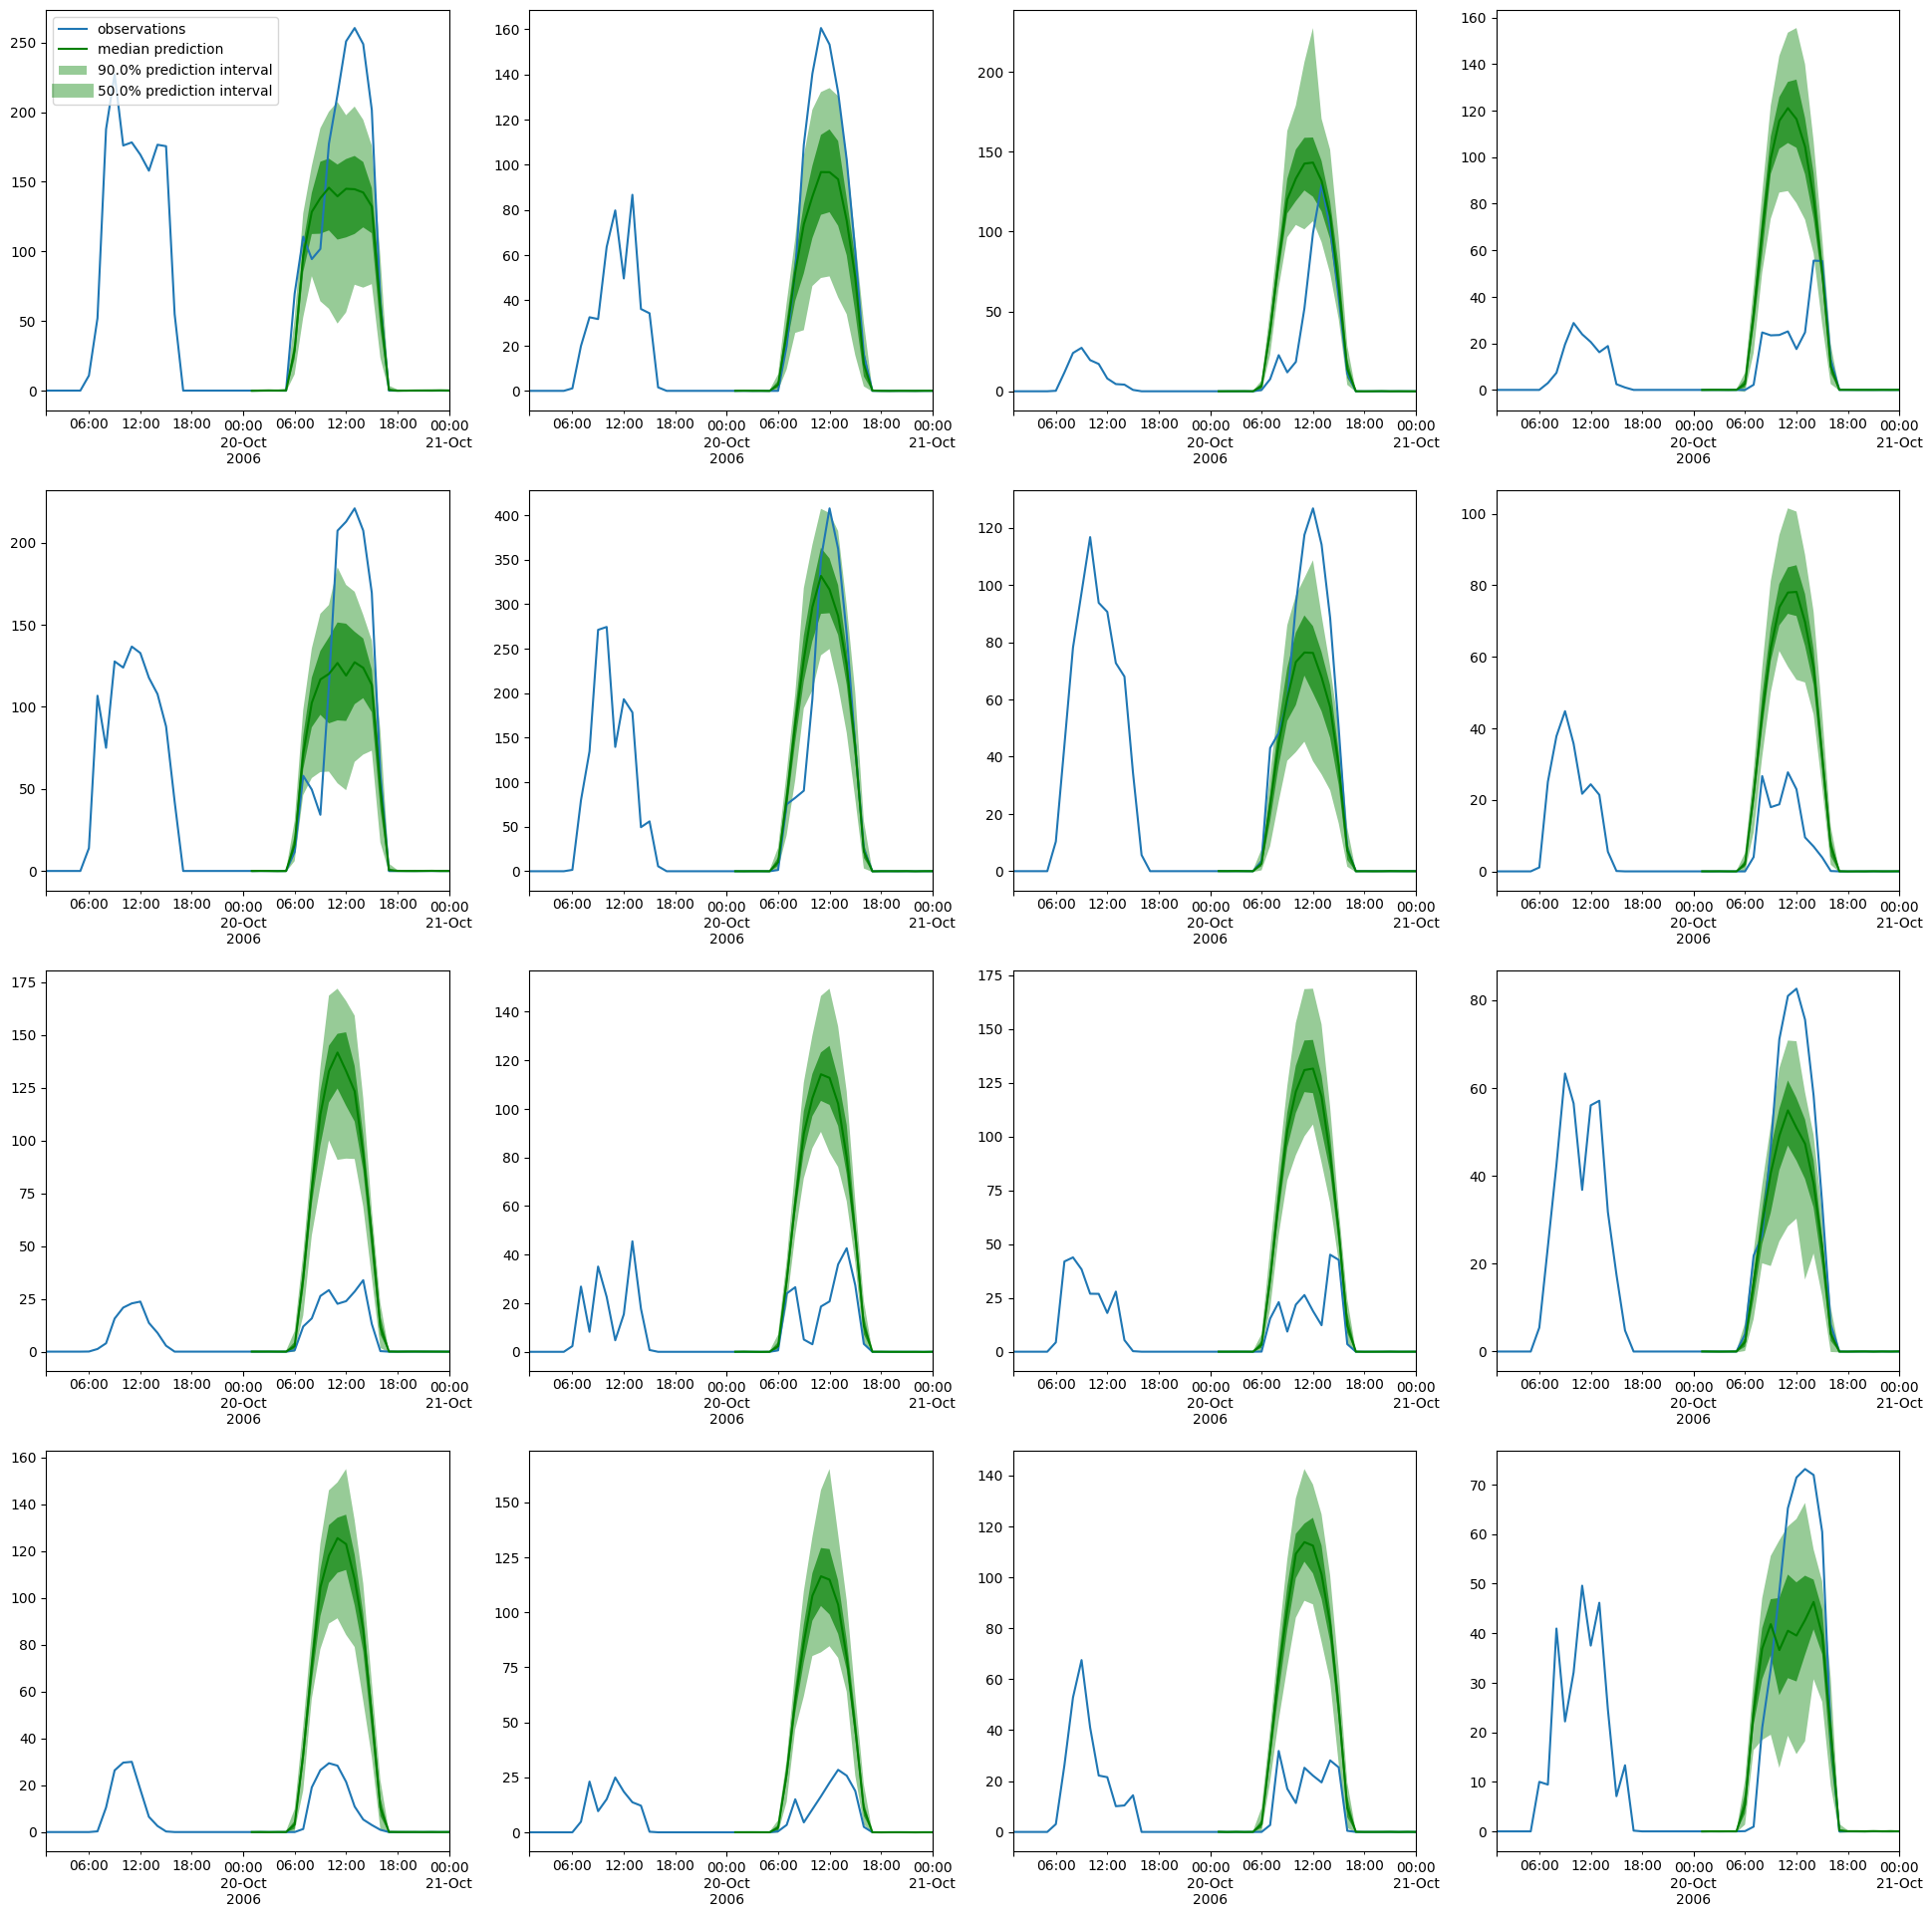

In [25]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()